# NLP-Facebook-Sentiment-Analyis-2

# Imports

In [32]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import re

from nltk.tokenize import word_tokenize

from transformers import AutoTokenizer


from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS
from sklearn.preprocessing import LabelEncoder

import tensorflow as tf
from tensorflow.keras.layers import Dense, Embedding, LSTM, Bidirectional
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping

# Functions

In [23]:
def check_for_nulls_dupes(df):
  print(f"The amount of NaN values: {df.isna().sum()}")
  print(f"The amount of Duplicated values: {df.duplicated().sum()}")

def check_class_imbalance(target):
  
  unique, counts = np.unique(target, return_counts=True)
  plt.figure(figsize=(10, 7))
  plt.pie(counts, labels=unique, autopct="%1.1f%%", startangle=140)
  plt.title("Target Class Breakdown")
  plt.legend()
  plt.show()
  
  plt.figure(figsize=(10, 7))
  sns.countplot(x=target)
  plt.title("Target Class Breakdown")
  plt.xlabel("Target Class")
  plt.ylabel("Counts")
  plt.xticks(rotation=45)
  plt.show()

def remove_stop_words(content):
  word_tokens = " ".join(word_tokenize(content))
  filtered_tokens = re.sub(r"[^a-zA-Z\s]", "", word_tokens).split(" ")
  filtered_word_tokens = [w.lower().strip() for w in filtered_tokens if w.lower() not in ENGLISH_STOP_WORDS]
  return " ".join(filtered_word_tokens).strip()

# EDA Analysis

In [4]:
df = pd.read_csv("/Users/maukanmir/Downloads/facebook_reviews.csv", nrows=10000)
df

,reviewId,userName,content,score,thumbsUpCount,reviewCreatedVersion,at,appVersion
0,bdc80475-1569-4ab7-941d-1418df2037a9,Joyce A Shultz,Very good,5,3,462.0.0.47.85,2024-06-05 04:34:12,462.0.0.47.85
1,c730747d-e911-4f2a-9361-a1512d0a618a,Keran Rigby,KarenRigby,5,2,NaN,2024-06-04 14:36:57,NaN
2,0c63a71b-c9b4-4219-a123-38f95028e09b,MD Mahbub,D Good,5,0,NaN,2024-06-03 17:21:39,NaN
3,5c78dff6-df96-4b0d-b7b1-6e3b7d0604b4,Rodolfo Sanotajr,Jayar sanotajr,5,0,NaN,2024-06-03 12:13:41,NaN
4,29096648-1c2d-4252-b943-a51e99e21ec6,Fidaullah Gilgit,Good,5,1,466.1.0.57.85,2024-06-02 17:11:55,466.1.0.57.85
...,...,...,...,...,...,...,...,...
9995,376a1563-7c81-44a6-87fe-f30ef4179536,Stephanie de blaauw,My group doesn't always send notifications and...,1,44,464.0.0.60.90,2024-05-23 21:06:38,464.0.0.60.90
9996,4e04dc99-85ad-4b4c-9d6b-5eab805e4464,jony Islam,Best app 🥰,5,0,464.0.0.60.90,2024-05-23 21:06:04,464.0.0.60.90
9997,713ed2dd-2f1e-466a-bd29-a09910e9de86,Debbie Hanson,Amazing snack bar! Great family experience!,5,0,464.0.0.60.90,2024-05-23 21:06:00,464.0.0.60.90
9998,a8cbaa8b-ca61-4d90-9692-e86beb7c4353,Rene Garza,miss you mom,5,0,464.0.0.60.90,2024-05-23 21:04:37,464.0.0.60.90


# Check For Nulls and Dupes

In [5]:
check_for_nulls_dupes(df)

The amount of NaN values: reviewId                   0
userName                   0
content                    0
score                      0
thumbsUpCount              0
reviewCreatedVersion    1781
at                         0
appVersion              1781
dtype: int64
The amount of Duplicated values: 0


In [6]:
df.dropna(inplace=True)

In [7]:
df.drop_duplicates(inplace=True)

In [8]:
df.shape

(8219, 8)

# Check For Class Imbalance

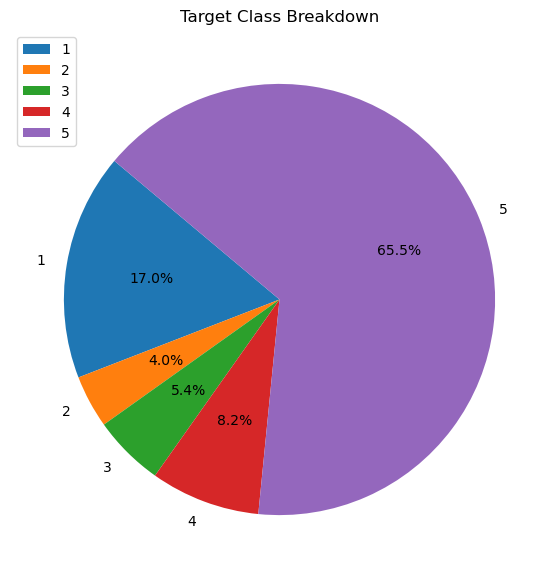

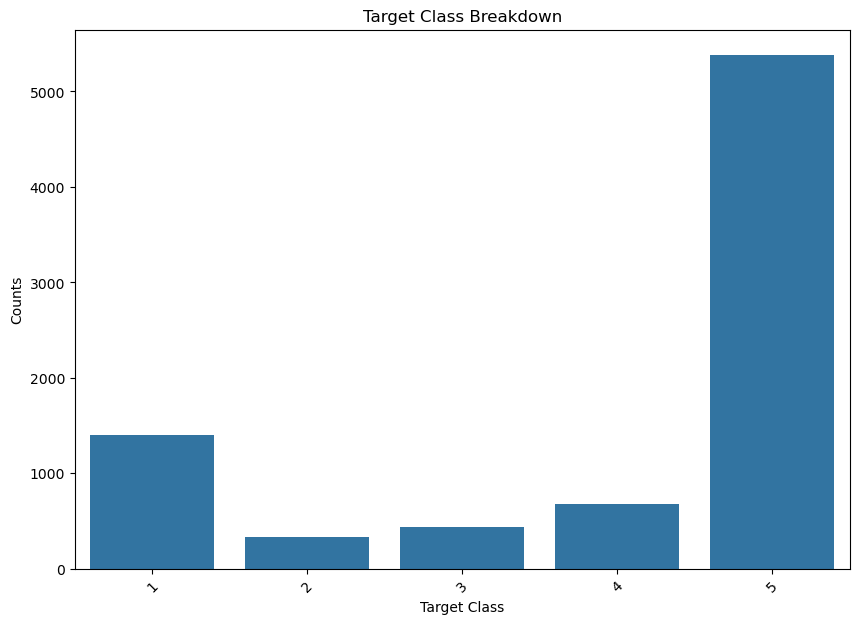

In [18]:
check_class_imbalance(df["score"])

# Class Imbalance exists

In [19]:
df.dtypes

reviewId                object
userName                object
content                 object
score                    int64
thumbsUpCount            int64
reviewCreatedVersion    object
at                      object
appVersion              object
dtype: object

# Drop Unused Columns

In [20]:
df.drop(["reviewId", "userName", "reviewCreatedVersion", "appVersion"],axis=1, inplace=True)

In [21]:
df.describe()

,score,thumbsUpCount
count,8219.000000,8219.000000
mean,4.011802,1.518311
std,1.548119,43.797141
min,1.000000,0.000000
25%,3.000000,0.000000
50%,5.000000,0.000000
75%,5.000000,0.000000
max,5.000000,2808.000000


# Data Preprocessing

In [24]:
df["content"] = df["content"].apply(remove_stop_words)

In [25]:
df["score"] = df["score"].apply(lambda x: 0 if x <=3 else 1)

<AxesSubplot:xlabel='Positive Review', ylabel='Negative Review'>

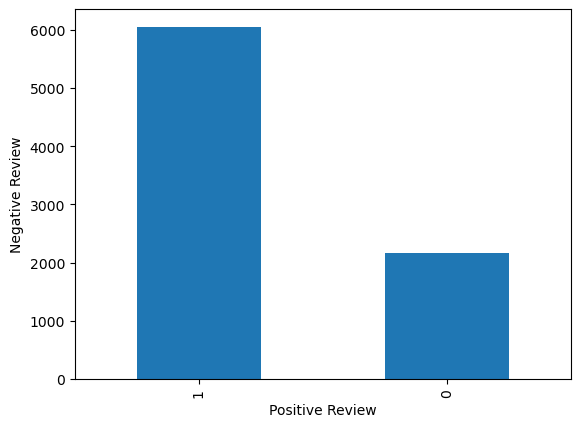

In [27]:
df["score"].value_counts().plot.bar(xlabel="Positive Review", ylabel="Negative Review")

# Check for empty Strings

In [ ]:
df = df[df['content'].str.strip() != '']

# Separate Feature Variables

In [31]:
X, y = df["content"], df["score"]

# Establish Bert Model

In [33]:
model = "distilbert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model)

# Labels

In [36]:
NUM_LABELS = len(np.unique(df["score"]))

# Tokenize Content

In [41]:
seq = X.tolist()
model_inputs = tokenizer(seq, padding=True, return_tensors="tf")

In [42]:
vocab_size = len(tokenizer.get_vocab()) +1
vocab_size

30523

# Create LSTM Model

In [44]:
model = Sequential()
model.add(Embedding(input_dim=vocab_size, output_dim=32))
model.add(Bidirectional(LSTM(32, activation="tanh")))
model.add(Dense(128, activation="relu"))
model.add(Dense(256, activation="relu"))
model.add(Dense(128, activation="relu"))
model.add(Dense(NUM_LABELS, activation="sigmoid"))
model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, None, 32)          976736    
                                                                 
 bidirectional_1 (Bidirectio  (None, 64)               16640     
 nal)                                                            
                                                                 
 dense_5 (Dense)             (None, 128)               8320      
                                                                 
 dense_6 (Dense)             (None, 256)               33024     
                                                                 
 dense_7 (Dense)             (None, 128)               32896     
                                                                 
 dense_8 (Dense)             (None, 2)                 258       
                                                      

In [45]:
dataset = tf.data.Dataset.from_tensor_slices((model_inputs["input_ids"], y))

In [46]:
dataset = dataset.cache()
dataset = dataset.shuffle(160000)
dataset = dataset.batch(16)
dataset = dataset.prefetch(8)

In [47]:
len_df = len(dataset)

train = dataset.take(int(len_df *.7))
test = dataset.skip(int(len_df *.7)).take(int(len_df *.2))
val =  dataset.skip(int(len_df *.9)).take(int(len_df *.1))

# Early Stopping Metric